#### Variational AutoEncoders

* Probabilistic Autoencoders
* Encoder takes an input and produces a learned mean **Z_mu** and a learned variance **Z_sigma** 
  * The mean and variance generated define a Normal distrbution 
  * The Final Encoding is then **Sampled** from this learnt **Normal Distribution**
* The decoder takes the sampled encoding and outputs a resembeling output to the input 

#### Convolutional Variational AutoEncoder 
* Convolutional autoencoders (CAEs) are unsupervised dimensionality reduction models composed by convolutional layers capable of creating compressed image representations.

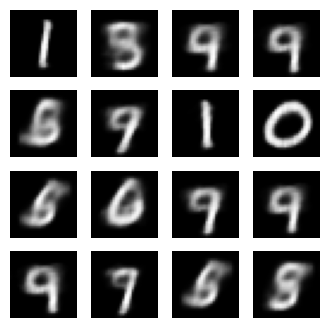

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-fogsawe7
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-fogsawe7
  Resolved https://github.com/tensorflow/docs to commit 0c78d6d8ad6ced9178a081d41ead24ae80d88958
  Preparing metadata (setup.py) ... done


In [20]:
from tensorflow import keras
from keras.models import Model
from keras import Input
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
generate_and_save_images(model, 0, test_sample)
import PIL
import imageio
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs.vis.embed as embed
import glob

In [2]:
# Load Images Data  (MNIST in this Case)
(x_train,y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Print shapes
print("Shape of X_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (60000, 28, 28)
Shape of y_train:  (60000,)
Shape of X_test:  (10000, 28, 28)
Shape of y_test:  (10000,)


In [4]:
# Define Preprocessing function for images
# Chose preprocessing based on images dataset
def preprocess_images(images):
  """
  
  """
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

# Preprocess images 
train_images = preprocess_images(x_train)
test_images = preprocess_images(x_test)

In [5]:
# Batching parameters
train_size = 60000
batch_size = 32
test_size = 10000

In [6]:
# Create batches from train and test dataset 
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

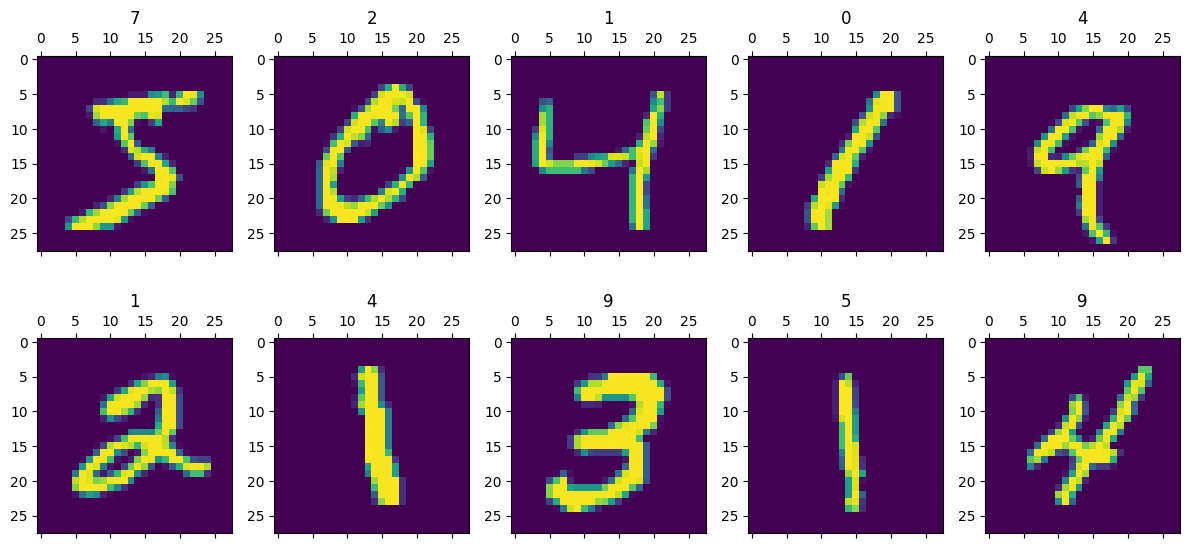

In [7]:
# Display the first images in the training set and their true labels
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(x_train[n])
        axs[i,j].set(title=y_test[n])
        n=n+1
plt.show() 

In [8]:
# Define Convolutional Variational AutoEncoder Class

class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim

# Define Decoder with 2 conv2d layer and one fully connected layer
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

# Decoder is the Mirrored Encoder but with 3 Deconvolution layers
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )


# Define Sampling function for latent dim sampling
  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

# Define Encoding function 
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

# 
  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

# Define Decoding function
  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [9]:
# Define Loss Function and Optimize
optimizer = tf.keras.optimizers.Adam(1e-4)


# VAE is trained by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)



In [10]:
# Define train_step function 

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [11]:
# Training 

epochs = 10
# Set the dimensionality of the latent space 
latent_dim = 2
# Examples to Generate 
num_examples_to_generate = 16

# Define random vector for generation 
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])


In [12]:
# Instantiate model
model = CVAE(latent_dim)

In [13]:
# Define generation loop function
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [14]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -156.6568145751953, time elapse for current epoch: 10.22347116470337


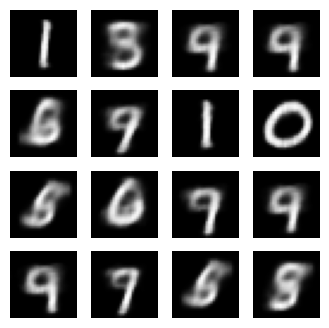

In [15]:
# Define training loop
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  clear_output(wait=True)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

(-0.5, 399.5, 399.5, -0.5)

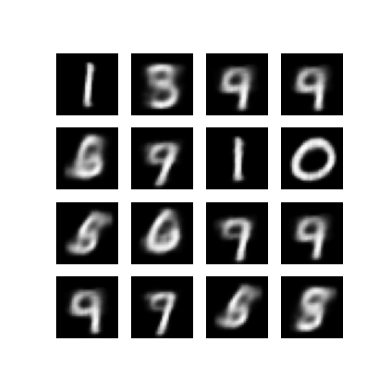

In [17]:
# Display last image from last epoch in training 
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

# Show img
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

In [21]:
# Save images generated during training as a GIF
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-21-5711ae792751>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-21-5711ae792751>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [22]:
# View GIF
embed.embed_file(anim_file)